In [1]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Cell 2: Install dependencies
!pip install -q torch torchvision
!pip install -q pycocotools opencv-python albumentations
!pip install -q matplotlib pillow numpy tqdm


In [3]:
# Cell 3: Imports
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cv2
import os
import pickle

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


PyTorch: 2.9.0+cu126
Torchvision: 0.24.0+cu126
CUDA: True
GPU: Tesla T4


In [4]:
# Cell 4: Configuration (UPDATED PATHS)
DATASET_PATH = "/content/drive/MyDrive/Cal_Estimation_Project/data/raw/foodseg103/FoodSeg103"
NUTRITION5K_PATH = "/content/drive/MyDrive/Cal_Estimation_Project/data/raw/nutrition5k"
OUTPUT_DIR = "/content/drive/MyDrive/Cal_Estimation_Project/maskrcnn_outputs"

# SUBSET CONFIGURATION
TRAIN_SAMPLES = 500
TEST_SAMPLES = 100
NUM_EPOCHS = 15

# MODEL PARAMETERS
NUM_CLASSES = 2  # 1 food class + background
BATCH_SIZE = 2
LEARNING_RATE = 0.005

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/checkpoints", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/predictions", exist_ok=True)

print(f"Configuration:")
print(f"  FoodSeg103: {DATASET_PATH}")
print(f"    Exists: {os.path.exists(DATASET_PATH)}")
print(f"  Nutrition5k: {NUTRITION5K_PATH}")
print(f"    Exists: {os.path.exists(NUTRITION5K_PATH)}")
print(f"  Train samples: {TRAIN_SAMPLES}")
print(f"  Test samples: {TEST_SAMPLES}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Expected time: ~40-50 minutes")


Configuration:
  FoodSeg103: /content/drive/MyDrive/Cal_Estimation_Project/data/raw/foodseg103/FoodSeg103
    Exists: True
  Nutrition5k: /content/drive/MyDrive/Cal_Estimation_Project/data/raw/nutrition5k
    Exists: True
  Train samples: 500
  Test samples: 100
  Epochs: 15
  Expected time: ~40-50 minutes


In [5]:
# Cell 5: FoodSeg103 Dataset for Mask R-CNN
class FoodSeg103MaskRCNN(Dataset):
    def __init__(self, root_path, split='train', max_samples=None):
        self.root = Path(root_path)
        self.split = split

        img_dir = self.root / "Images" / "img_dir" / split
        ann_dir = self.root / "Images" / "ann_dir" / split

        print(f"Loading {split} split...")
        print(f"  Image dir: {img_dir}")
        print(f"  Ann dir: {ann_dir}")

        if not img_dir.exists():
            print(f"   Image directory not found")
            self.images = []
            self.masks = []
            return

        if not ann_dir.exists():
            print(f"  Annotation directory not found")
            self.images = []
            self.masks = []
            return

        images = sorted(list(img_dir.glob("*.jpg")))
        annotations = sorted(list(ann_dir.glob("*.png")))

        print(f"  Found {len(images)} images, {len(annotations)} annotations")

        img_dict = {img.stem: str(img) for img in images}
        ann_dict = {ann.stem: str(ann) for ann in annotations}

        common_names = sorted(set(img_dict.keys()) & set(ann_dict.keys()))
        print(f"  Matched pairs: {len(common_names)}")

        if max_samples:
            common_names = common_names[:max_samples]
            print(f"  Limited to: {len(common_names)}")

        self.images = [img_dict[name] for name in common_names]
        self.masks = [ann_dict[name] for name in common_names]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        image = np.array(image)
        mask = np.array(mask)

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids != 0]

        masks_list = []
        boxes_list = []
        labels_list = []

        for obj_id in obj_ids:
            binary_mask = (mask == obj_id).astype(np.uint8)

            pos = np.where(binary_mask)
            if len(pos[0]) == 0:
                continue

            xmin = int(np.min(pos[1]))
            xmax = int(np.max(pos[1]))
            ymin = int(np.min(pos[0]))
            ymax = int(np.max(pos[0]))

            if xmax <= xmin or ymax <= ymin:
                continue

            if xmax - xmin < 2:
                xmax = xmin + 2
            if ymax - ymin < 2:
                ymax = ymin + 2

            masks_list.append(binary_mask)
            boxes_list.append([xmin, ymin, xmax, ymax])
            labels_list.append(1)

        if len(masks_list) == 0:
            h, w = image.shape[:2]
            masks_list = [np.zeros((h, w), dtype=np.uint8)]
            boxes_list = [[0, 0, 1, 1]]
            labels_list = [0]

        masks_array = np.array(masks_list)
        boxes_array = np.array(boxes_list, dtype=np.float32)
        labels_array = np.array(labels_list, dtype=np.int64)

        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        masks = torch.from_numpy(masks_array).to(torch.uint8)
        boxes = torch.from_numpy(boxes_array)
        labels = torch.from_numpy(labels_array)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([idx])
        }

        return image, target


In [6]:
print("="*60)
train_dataset = FoodSeg103MaskRCNN(DATASET_PATH, 'train', TRAIN_SAMPLES)
print("="*60)
test_dataset = FoodSeg103MaskRCNN(DATASET_PATH, 'test', TEST_SAMPLES)
print("="*60)

print(f"\nTrain: {len(train_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

if len(train_dataset) > 0:
    sample_img, sample_target = train_dataset[0]
    print(f"\nSample test:")
    print(f"  Image shape: {sample_img.shape}")
    print(f"  Num instances: {len(sample_target['boxes'])}")


Loading train split...
  Image dir: /content/drive/MyDrive/Cal_Estimation_Project/data/raw/foodseg103/FoodSeg103/Images/img_dir/train
  Ann dir: /content/drive/MyDrive/Cal_Estimation_Project/data/raw/foodseg103/FoodSeg103/Images/ann_dir/train
  Found 4983 images, 4983 annotations
  Matched pairs: 4983
  Limited to: 500
Loading test split...
  Image dir: /content/drive/MyDrive/Cal_Estimation_Project/data/raw/foodseg103/FoodSeg103/Images/img_dir/test
  Ann dir: /content/drive/MyDrive/Cal_Estimation_Project/data/raw/foodseg103/FoodSeg103/Images/ann_dir/test
  Found 2135 images, 2135 annotations
  Matched pairs: 2135
  Limited to: 100

Train: 500 samples
Test: 100 samples

Sample test:
  Image shape: torch.Size([3, 384, 512])
  Num instances: 3


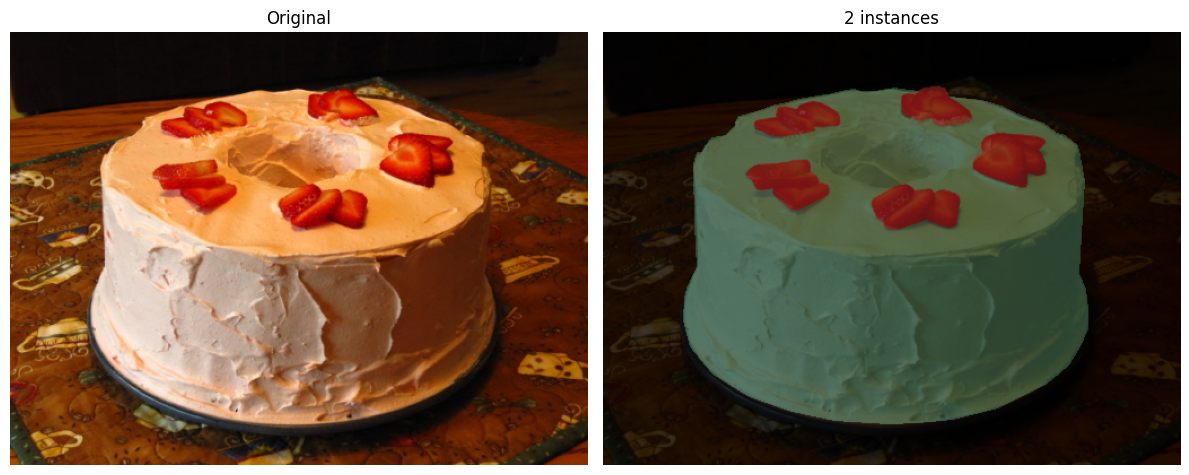

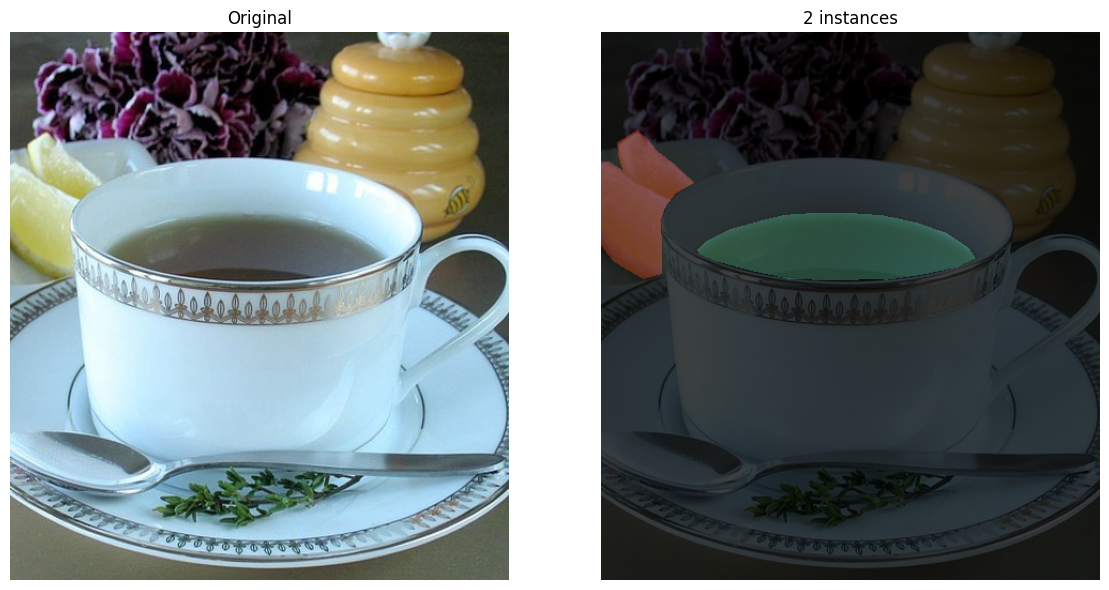

In [7]:
# Cell 6: Visualize dataset
def visualize_instance_masks(dataset, idx):
    image, target = dataset[idx]

    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    masks = target['masks'].numpy()
    boxes = target['boxes'].numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image_np)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(image_np)
    np.random.seed(42)
    for i, (mask, box) in enumerate(zip(masks, boxes)):
        color = np.random.random(3)
        colored_mask = np.zeros((*mask.shape, 3))
        colored_mask[mask == 1] = color
        axes[1].imshow(colored_mask, alpha=0.5)

    axes[1].set_title(f'{len(masks)} instances')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

if len(train_dataset) > 0:
    for i in range(2):
        idx = np.random.randint(0, len(train_dataset))
        visualize_instance_masks(train_dataset, idx)


In [8]:
# Cell 7: Build Mask R-CNN model
def get_maskrcnn_model(num_classes):
    model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

model = get_maskrcnn_model(NUM_CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model loaded on {device}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth


100%|██████████| 177M/177M [00:00<00:00, 242MB/s]


Model loaded on cuda
Parameters: 45,880,411


In [9]:
# Cell 8: DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 250
Test batches: 50


In [10]:
# Cell 9: Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)

print("Optimizer ready")


Optimizer ready


In [11]:
# Cell 10: Training loop
print("="*60)
print("STARTING TRAINING")
print("="*60)

best_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        progress_bar.set_postfix({'loss': losses.item()})

    lr_scheduler.step()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), f"{OUTPUT_DIR}/checkpoints/maskrcnn_best.pth")

torch.save(model.state_dict(), f"{OUTPUT_DIR}/checkpoints/maskrcnn_final.pth")

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Best loss: {best_loss:.4f}")


STARTING TRAINING


Epoch 1/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 - Loss: 0.8797


Epoch 2/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2 - Loss: 0.6338


Epoch 3/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3 - Loss: 0.5189


Epoch 4/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4 - Loss: 0.4565


Epoch 5/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5 - Loss: 0.4084


Epoch 6/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6 - Loss: 0.3406


Epoch 7/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7 - Loss: 0.3189


Epoch 8/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8 - Loss: 0.2993


Epoch 9/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9 - Loss: 0.2896


Epoch 10/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10 - Loss: 0.2833


Epoch 11/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11 - Loss: 0.2770


Epoch 12/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12 - Loss: 0.2768


Epoch 13/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13 - Loss: 0.2758


Epoch 14/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14 - Loss: 0.2747


Epoch 15/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15 - Loss: 0.2748

TRAINING COMPLETE
Best loss: 0.2747


In [12]:
# Cell 11: Inference functions
def predict_maskrcnn(image_path, model, device, threshold=0.5):
    model.eval()

    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.0

    with torch.no_grad():
        prediction = model([image_tensor.to(device)])[0]

    keep = prediction['scores'] > threshold

    boxes = prediction['boxes'][keep].cpu().numpy()
    masks = prediction['masks'][keep].cpu().numpy()
    labels = prediction['labels'][keep].cpu().numpy()
    scores = prediction['scores'][keep].cpu().numpy()

    return image, boxes, masks, labels, scores

def visualize_maskrcnn_prediction(image, boxes, masks, labels, scores):
    image_np = np.array(image)
    overlay = image_np.copy()

    np.random.seed(42)
    colors = [np.random.randint(50, 255, 3) for _ in range(len(masks))]

    for i, (mask, color) in enumerate(zip(masks, colors)):
        binary_mask = mask[0] > 0.5
        overlay[binary_mask] = (
            image_np[binary_mask] * 0.4 + color * 0.6
        ).astype(np.uint8)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    axes[0].imshow(image)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(overlay)
    axes[1].set_title(f'Segmentation ({len(masks)} items)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Detected {len(masks)} food items")

print("Inference functions ready")


Inference functions ready


In [13]:
# Cell 12: Test on FoodSeg103
print("Testing on FoodSeg103...")

for i, img_path in enumerate(test_dataset.images[:5]):
    print(f"\nImage {i+1}/5")

    image, boxes, masks, labels, scores = predict_maskrcnn(
        img_path, model, device, threshold=0.5
    )

    visualize_maskrcnn_prediction(image, boxes, masks, labels, scores)


Output hidden; open in https://colab.research.google.com to view.

In [14]:
# Cell 13: Nutrition5k Dataset (FIXED - COMPLETE)
import pandas as pd
import io

class Nutrition5kDataset(Dataset):
    def __init__(self, root_path, max_samples=None):
        self.root = Path(root_path)
        pkl_file = self.root / "dish_images.pkl"

        print(f"Loading Nutrition5k from: {pkl_file}")

        if not pkl_file.exists():
            print(f"  ❌ {pkl_file} not found")
            self.images = []
            self.dish_ids = []
            return

        with open(pkl_file, 'rb') as f:
            df = pickle.load(f)

        print(f"  DataFrame shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")

        self.images = []
        self.dish_ids = []

        temp_dir = "/tmp/nutrition5k_images"
        os.makedirs(temp_dir, exist_ok=True)

        print("  Converting images from bytes...")
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
            dish_id = row['dish']
            rgb_bytes = row['rgb_image']

            try:
                image = Image.open(io.BytesIO(rgb_bytes))
                temp_path = os.path.join(temp_dir, f"{dish_id}.png")
                image.save(temp_path)

                self.images.append(temp_path)
                self.dish_ids.append(dish_id)
            except Exception as e:
                print(f"  Error processing {dish_id}: {e}")
                continue

        if max_samples and len(self.images) > max_samples:
            self.images = self.images[:max_samples]
            self.dish_ids = self.dish_ids[:max_samples]

        print(f"  Total images loaded: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

nutrition5k_dataset = Nutrition5kDataset(NUTRITION5K_PATH, max_samples=200)


Loading Nutrition5k from: /content/drive/MyDrive/Cal_Estimation_Project/data/raw/nutrition5k/dish_images.pkl
  DataFrame shape: (3490, 3)
  Columns: ['dish', 'rgb_image', 'depth_image']
  Converting images from bytes...


Processing:   0%|          | 0/3490 [00:00<?, ?it/s]

  Total images loaded: 200


In [15]:
# Cell 14: Test on Nutrition5k
if len(nutrition5k_dataset) > 0:
    print("Testing on Nutrition5k...")

    for i in range(min(5, len(nutrition5k_dataset))):
        img_path = nutrition5k_dataset[i]
        print(f"\nNutrition5k Image {i+1}/5")

        image, boxes, masks, labels, scores = predict_maskrcnn(
            img_path, model, device, threshold=0.5
        )

        visualize_maskrcnn_prediction(image, boxes, masks, labels, scores)
else:
    print("Nutrition5k dataset not loaded")


Output hidden; open in https://colab.research.google.com to view.

In [16]:
# Cell 15: Save FoodSeg103 predictions
output_pred_dir = f"{OUTPUT_DIR}/predictions/foodseg103"
os.makedirs(output_pred_dir, exist_ok=True)

print("Saving FoodSeg103 predictions...")

for img_path in tqdm(test_dataset.images):
    image, boxes, masks, labels, scores = predict_maskrcnn(
        img_path, model, device, threshold=0.5
    )

    image_np = np.array(image)
    overlay = image_np.copy()

    np.random.seed(42)
    for mask in masks:
        color = np.random.randint(50, 255, 3)
        binary_mask = mask[0] > 0.5
        overlay[binary_mask] = (
            image_np[binary_mask] * 0.4 + color * 0.6
        ).astype(np.uint8)

    combined = np.hstack([image_np, overlay])

    filename = os.path.basename(img_path).replace('.jpg', '_maskrcnn.png')
    plt.imsave(os.path.join(output_pred_dir, filename), combined)

print(f"Saved to: {output_pred_dir}")


Saving FoodSeg103 predictions...


  0%|          | 0/100 [00:00<?, ?it/s]

Saved to: /content/drive/MyDrive/Cal_Estimation_Project/maskrcnn_outputs/predictions/foodseg103


In [17]:
# Cell 16: Save Nutrition5k predictions (FIXED)
if len(nutrition5k_dataset) > 0:
    output_pred_dir = f"{OUTPUT_DIR}/predictions/nutrition5k"
    os.makedirs(output_pred_dir, exist_ok=True)

    print("Saving Nutrition5k predictions...")

    for idx, img_path in enumerate(tqdm(nutrition5k_dataset.images)):
        try:
            image, boxes, masks, labels, scores = predict_maskrcnn(
                img_path, model, device, threshold=0.5
            )

            image_np = np.array(image)
            overlay = image_np.copy()

            np.random.seed(42)
            for mask in masks:
                color = np.random.randint(50, 255, 3)
                binary_mask = mask[0] > 0.5
                overlay[binary_mask] = (
                    image_np[binary_mask] * 0.4 + color * 0.6
                ).astype(np.uint8)

            combined = np.hstack([image_np, overlay])

            dish_id = nutrition5k_dataset.dish_ids[idx]
            filename = f"{dish_id}_maskrcnn.png"
            plt.imsave(os.path.join(output_pred_dir, filename), combined)

        except Exception as e:
            print(f"Error processing image {idx}: {e}")
            continue

    print(f"Saved to: {output_pred_dir}")
else:
    print("No Nutrition5k images to process")


Saving Nutrition5k predictions...


  0%|          | 0/200 [00:00<?, ?it/s]

Saved to: /content/drive/MyDrive/Cal_Estimation_Project/maskrcnn_outputs/predictions/nutrition5k


Extracted 5 food instances


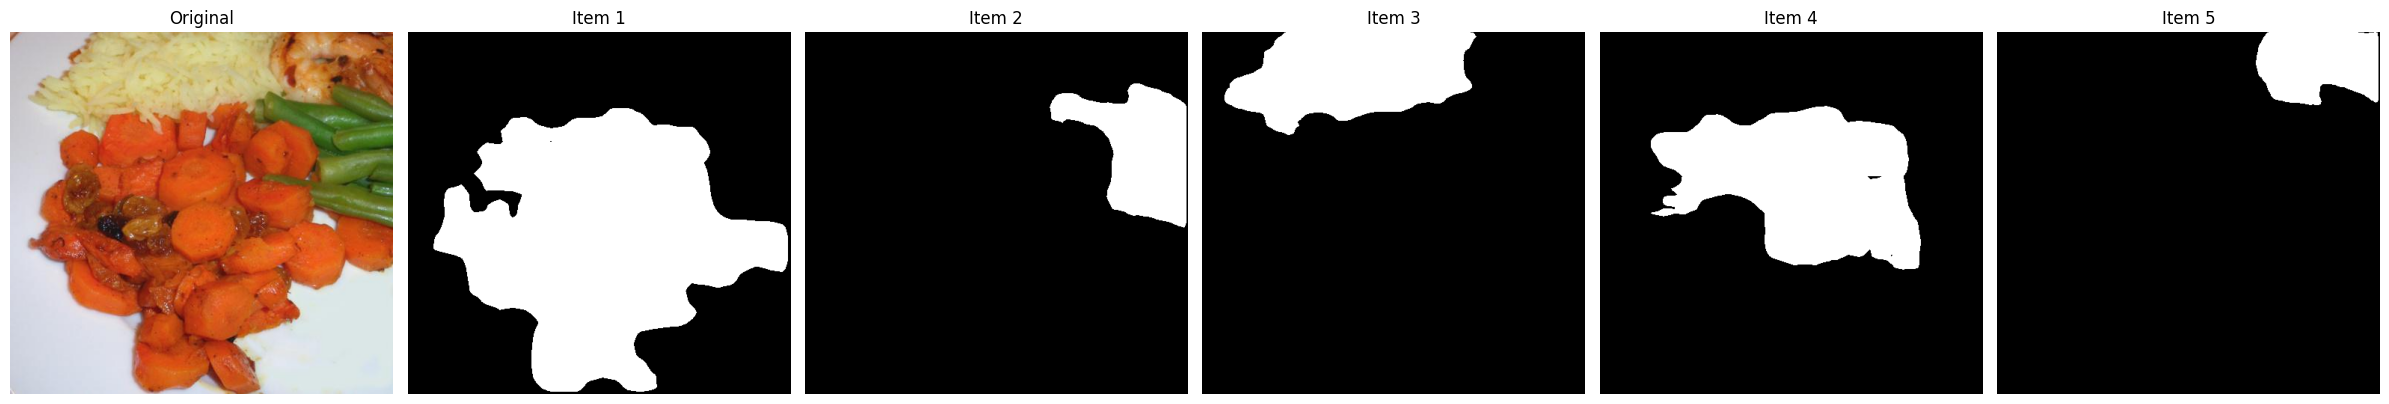

In [18]:
# Cell 17: Extract individual masks
def extract_instance_masks(image_path, model, device, threshold=0.5):
    image, boxes, masks, labels, scores = predict_maskrcnn(
        image_path, model, device, threshold
    )

    instances = []
    for i, (mask, box, label, score) in enumerate(zip(masks, boxes, labels, scores)):
        binary_mask = (mask[0] > 0.5).astype(np.uint8) * 255

        instances.append({
            'mask': binary_mask,
            'box': box,
            'label': int(label),
            'score': float(score),
            'instance_id': i
        })

    return image, instances

if len(test_dataset) > 0:
    test_img = test_dataset.images[0]
    image, instances = extract_instance_masks(test_img, model, device)

    print(f"Extracted {len(instances)} food instances")

    fig, axes = plt.subplots(1, len(instances)+1, figsize=(4*(len(instances)+1), 4))

    axes[0].imshow(image)
    axes[0].set_title('Original')
    axes[0].axis('off')

    for i, inst in enumerate(instances):
        axes[i+1].imshow(inst['mask'], cmap='gray')
        axes[i+1].set_title(f"Item {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()


In [19]:
# Cell 18: Summary
print("="*60)
print("MASK R-CNN TRAINING COMPLETE")
print("="*60)
print(f"\nModel: Mask R-CNN ResNet50-FPN")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Best loss: {best_loss:.4f}")
print(f"\nSaved models:")
print(f"  {OUTPUT_DIR}/checkpoints/maskrcnn_best.pth")
print(f"  {OUTPUT_DIR}/checkpoints/maskrcnn_final.pth")
print(f"\nPredictions:")
print(f"  {OUTPUT_DIR}/predictions/foodseg103/")
print(f"  {OUTPUT_DIR}/predictions/nutrition5k/")
print("\nKey improvements:")
print("   Each food item = unique color")
print("   Instance segmentation")
print("   Better boundaries")
print("="*60)


MASK R-CNN TRAINING COMPLETE

Model: Mask R-CNN ResNet50-FPN
Training samples: 500
Test samples: 100
Epochs: 15
Best loss: 0.2747

Saved models:
  /content/drive/MyDrive/Cal_Estimation_Project/maskrcnn_outputs/checkpoints/maskrcnn_best.pth
  /content/drive/MyDrive/Cal_Estimation_Project/maskrcnn_outputs/checkpoints/maskrcnn_final.pth

Predictions:
  /content/drive/MyDrive/Cal_Estimation_Project/maskrcnn_outputs/predictions/foodseg103/
  /content/drive/MyDrive/Cal_Estimation_Project/maskrcnn_outputs/predictions/nutrition5k/

Key improvements:
   Each food item = unique color
   Instance segmentation
   Better boundaries


In [21]:
# ============================================================
# CACHE UTILITIES FOR NOTEBOOK 04 (NEW)
# ============================================================

import pickle
import os

CACHE_DIR = "/content/drive/MyDrive/Cal_Estimation_Project/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_cache(obj, name="04_cache"):
    path = f"{CACHE_DIR}/{name}.pkl"
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    print(f"✔ Saved cache → {path}")

def load_cache(name="04_cache"):
    path = f"{CACHE_DIR}/{name}.pkl"
    if os.path.exists(path):
        print(f"✔ Loaded cache → {path}")
        with open(path, "rb") as f:
            return pickle.load(f)
    return None


In [22]:
# ============================================================
# SAVE CACHE FOR NOTEBOOK 04 (NEW)
# ============================================================

cache_data = {
    "maskrcnn_best": f"{OUTPUT_DIR}/checkpoints/maskrcnn_best.pth",
    "maskrcnn_final": f"{OUTPUT_DIR}/checkpoints/maskrcnn_final.pth",
    "num_train_samples": len(train_dataset),
    "num_test_samples": len(test_dataset),
    "output_predictions": f"{OUTPUT_DIR}/predictions/"
}

save_cache(cache_data, "04_cache")


✔ Saved cache → /content/drive/MyDrive/Cal_Estimation_Project/cache/04_cache.pkl
